In [65]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.options.display.width = 120
pd.options.display.float_format = '{:.2f}'.format

In [67]:
source_data = r'./../data/NSW/processed_data.csv'

In [68]:
source_df = pd.read_csv(source_data).set_index('Unnamed: 0')
print(source_df)

                     PREDISPATCHSEQNO  PERIODID  FORECASTDEMAND  TOTALDEMAND  TEMPERATURE  totaldemand   rrp  \
Unnamed: 0                                                                                                     
2010-01-01 00:30:00     2009123083.11     36.50         7680.51      7809.31        22.90      7809.31 21.50   
2010-01-01 01:00:00     2009123083.92     37.00         7428.97      7483.69        22.60      7483.69 20.98   
2010-01-01 01:30:00     2009123084.72     37.50         7084.80      7117.23        22.50      7117.23 20.06   
2010-01-01 02:00:00     2009123085.51     38.00         6751.37      6812.03        22.50      6812.03 17.93   
2010-01-01 02:30:00     2009123086.29     38.50         6484.27      6544.33        22.40      6544.33 17.43   
...                               ...       ...             ...          ...          ...          ...   ...   
2021-03-17 22:00:00     2021031678.94     34.00         7317.70      7419.77        19.70      7419.77 3

In [69]:
print(source_df.isna().sum())

PREDISPATCHSEQNO              0
PERIODID                      0
FORECASTDEMAND                0
TOTALDEMAND                   0
TEMPERATURE                   0
totaldemand                   0
rrp                           0
smoothed_FORECASTDEMAND       0
smoothed_TOTALDEMAND          0
smoothed_TEMPERATURE          0
FORECASTDEMAND_daily         33
TOTALDEMAND_daily            33
normalized_TOTALDEMAND        0
normalized_FORECASTDEMAND     0
normalized_TEMPERATURE        0
dtype: int64


In [70]:
print(source_df.columns)

Index(['PREDISPATCHSEQNO', 'PERIODID', 'FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE', 'totaldemand', 'rrp',
       'smoothed_FORECASTDEMAND', 'smoothed_TOTALDEMAND', 'smoothed_TEMPERATURE', 'FORECASTDEMAND_daily',
       'TOTALDEMAND_daily', 'normalized_TOTALDEMAND', 'normalized_FORECASTDEMAND', 'normalized_TEMPERATURE'],
      dtype='object')


In [71]:
print(source_df)

                     PREDISPATCHSEQNO  PERIODID  FORECASTDEMAND  TOTALDEMAND  TEMPERATURE  totaldemand   rrp  \
Unnamed: 0                                                                                                     
2010-01-01 00:30:00     2009123083.11     36.50         7680.51      7809.31        22.90      7809.31 21.50   
2010-01-01 01:00:00     2009123083.92     37.00         7428.97      7483.69        22.60      7483.69 20.98   
2010-01-01 01:30:00     2009123084.72     37.50         7084.80      7117.23        22.50      7117.23 20.06   
2010-01-01 02:00:00     2009123085.51     38.00         6751.37      6812.03        22.50      6812.03 17.93   
2010-01-01 02:30:00     2009123086.29     38.50         6484.27      6544.33        22.40      6544.33 17.43   
...                               ...       ...             ...          ...          ...          ...   ...   
2021-03-17 22:00:00     2021031678.94     34.00         7317.70      7419.77        19.70      7419.77 3

In [72]:
# updated_df.rename(columns = {'Unnamed: 0':'datetime'},inplace=True)

In [73]:
print(source_df.dtypes)

PREDISPATCHSEQNO             float64
PERIODID                     float64
FORECASTDEMAND               float64
TOTALDEMAND                  float64
TEMPERATURE                  float64
totaldemand                  float64
rrp                          float64
smoothed_FORECASTDEMAND      float64
smoothed_TOTALDEMAND         float64
smoothed_TEMPERATURE         float64
FORECASTDEMAND_daily         float64
TOTALDEMAND_daily            float64
normalized_TOTALDEMAND       float64
normalized_FORECASTDEMAND    float64
normalized_TEMPERATURE       float64
dtype: object


In [74]:
# source_df.set_index('datetime')

In [75]:
updated_df = source_df

In [76]:
print(updated_df.index)

Index(['2010-01-01 00:30:00', '2010-01-01 01:00:00', '2010-01-01 01:30:00', '2010-01-01 02:00:00',
       '2010-01-01 02:30:00', '2010-01-01 03:00:00', '2010-01-01 03:30:00', '2010-01-01 04:00:00',
       '2010-01-01 04:30:00', '2010-01-01 05:00:00',
       ...
       '2021-03-17 19:30:00', '2021-03-17 20:00:00', '2021-03-17 20:30:00', '2021-03-17 21:00:00',
       '2021-03-17 21:30:00', '2021-03-17 22:00:00', '2021-03-17 22:30:00', '2021-03-17 23:00:00',
       '2021-03-17 23:30:00', '2021-03-18 00:00:00'],
      dtype='object', name='Unnamed: 0', length=194589)


In [77]:
updated_df.index=pd.to_datetime(updated_df.index)

Dropped Forecast_Daily and TotalDemand_daily - contained 33 N/A's.

In [78]:
updated_df.drop(['FORECASTDEMAND_daily','TOTALDEMAND_daily'],axis=1,inplace=True)

In [79]:
print(updated_df.isna().sum())

PREDISPATCHSEQNO             0
PERIODID                     0
FORECASTDEMAND               0
TOTALDEMAND                  0
TEMPERATURE                  0
totaldemand                  0
rrp                          0
smoothed_FORECASTDEMAND      0
smoothed_TOTALDEMAND         0
smoothed_TEMPERATURE         0
normalized_TOTALDEMAND       0
normalized_FORECASTDEMAND    0
normalized_TEMPERATURE       0
dtype: int64


In [80]:
updated_df

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,TOTALDEMAND,TEMPERATURE,totaldemand,rrp,smoothed_FORECASTDEMAND,smoothed_TOTALDEMAND,smoothed_TEMPERATURE,normalized_TOTALDEMAND,normalized_FORECASTDEMAND,normalized_TEMPERATURE
Unnamed: 0,,,,,,,,,,,,,
2010-01-01 00:30:00,2009123083.11,36.50,7680.51,7809.31,22.90,7809.31,21.50,7699.97,7782.00,25.23,-0.23,-0.33,0.92
2010-01-01 01:00:00,2009123083.92,37.00,7428.97,7483.69,22.60,7483.69,20.98,7690.57,7774.00,25.27,-0.48,-0.52,0.87
2010-01-01 01:30:00,2009123084.72,37.50,7084.80,7117.23,22.50,7117.23,20.06,7681.34,7766.97,25.30,-0.77,-0.78,0.85
2010-01-01 02:00:00,2009123085.51,38.00,6751.37,6812.03,22.50,6812.03,17.93,7672.75,7760.41,25.34,-1.00,-1.04,0.85
2010-01-01 02:30:00,2009123086.29,38.50,6484.27,6544.33,22.40,6544.33,17.43,7665.72,7756.32,25.37,-1.21,-1.24,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17 22:00:00,2021031678.94,34.00,7317.70,7419.77,19.70,7419.77,32.00,7400.37,7422.86,19.71,-0.53,-0.60,0.37
2021-03-17 22:30:00,2021031679.79,34.50,7266.89,7417.91,19.50,7417.91,37.01,7399.72,7424.36,19.69,-0.53,-0.64,0.34
2021-03-17 23:00:00,2021031680.64,35.00,7173.87,7287.32,19.10,7287.32,34.49,7399.13,7425.78,19.67,-0.63,-0.71,0.27


In [81]:
# updated_df.set_index('datetime')

In [82]:
# new_df = updated_df

In [83]:
print(updated_df.head())

                     PREDISPATCHSEQNO  PERIODID  FORECASTDEMAND  TOTALDEMAND  TEMPERATURE  totaldemand   rrp  \
Unnamed: 0                                                                                                     
2010-01-01 00:30:00     2009123083.11     36.50         7680.51      7809.31        22.90      7809.31 21.50   
2010-01-01 01:00:00     2009123083.92     37.00         7428.97      7483.69        22.60      7483.69 20.98   
2010-01-01 01:30:00     2009123084.72     37.50         7084.80      7117.23        22.50      7117.23 20.06   
2010-01-01 02:00:00     2009123085.51     38.00         6751.37      6812.03        22.50      6812.03 17.93   
2010-01-01 02:30:00     2009123086.29     38.50         6484.27      6544.33        22.40      6544.33 17.43   

                     smoothed_FORECASTDEMAND  smoothed_TOTALDEMAND  smoothed_TEMPERATURE  normalized_TOTALDEMAND  \
Unnamed: 0                                                                                         

In [84]:
demand = updated_df.copy()
demand = demand[['totaldemand']]
demand.loc[:, 'dow'] = demand.index.dayofweek
demand.loc[:, 'doy'] = demand.index.dayofyear
demand.loc[:, 'year'] = demand.index.year
demand.loc[:, 'month'] = demand.index.month
demand.loc[:, 'quarter'] = demand.index.quarter
demand.loc[:, 'hour'] = demand.index.hour


In [85]:
print(demand.head())

                     totaldemand  dow  doy  year  month  quarter  hour
Unnamed: 0                                                            
2010-01-01 00:30:00      7809.31    4    1  2010      1        1     0
2010-01-01 01:00:00      7483.69    4    1  2010      1        1     1
2010-01-01 01:30:00      7117.23    4    1  2010      1        1     1
2010-01-01 02:00:00      6812.03    4    1  2010      1        1     2
2010-01-01 02:30:00      6544.33    4    1  2010      1        1     2


In [86]:
print(demand.iloc[45:60])

                     totaldemand  dow  doy  year  month  quarter  hour
Unnamed: 0                                                            
2010-01-01 23:00:00      8041.77    4    1  2010      1        1    23
2010-01-01 23:30:00      7782.68    4    1  2010      1        1    23
2010-01-02 00:00:00      7574.85    5    2  2010      1        1     0
2010-01-02 00:30:00      7343.30    5    2  2010      1        1     0
2010-01-02 01:00:00      7099.73    5    2  2010      1        1     1
2010-01-02 01:30:00      6779.80    5    2  2010      1        1     1
2010-01-02 02:00:00      6497.47    5    2  2010      1        1     2
2010-01-02 02:30:00      6347.69    5    2  2010      1        1     2
2010-01-02 03:00:00      6223.64    5    2  2010      1        1     3
2010-01-02 03:30:00      6182.07    5    2  2010      1        1     3
2010-01-02 04:00:00      6140.82    5    2  2010      1        1     4
2010-01-02 04:30:00      6224.48    5    2  2010      1        1     4
2010-0

Merge to the updated_df

In [87]:
print(demand.isna().sum())

totaldemand    0
dow            0
doy            0
year           0
month          0
quarter        0
hour           0
dtype: int64


In [88]:
print(demand.index)

DatetimeIndex(['2010-01-01 00:30:00', '2010-01-01 01:00:00', '2010-01-01 01:30:00', '2010-01-01 02:00:00',
               '2010-01-01 02:30:00', '2010-01-01 03:00:00', '2010-01-01 03:30:00', '2010-01-01 04:00:00',
               '2010-01-01 04:30:00', '2010-01-01 05:00:00',
               ...
               '2021-03-17 19:30:00', '2021-03-17 20:00:00', '2021-03-17 20:30:00', '2021-03-17 21:00:00',
               '2021-03-17 21:30:00', '2021-03-17 22:00:00', '2021-03-17 22:30:00', '2021-03-17 23:00:00',
               '2021-03-17 23:30:00', '2021-03-18 00:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=194589, freq=None)


In [89]:
final_df = pd.merge(updated_df, demand, left_index =True, right_index=True)

In [90]:
print(final_df)

                     PREDISPATCHSEQNO  PERIODID  FORECASTDEMAND  TOTALDEMAND  TEMPERATURE  totaldemand_x   rrp  \
Unnamed: 0                                                                                                       
2010-01-01 00:30:00     2009123083.11     36.50         7680.51      7809.31        22.90        7809.31 21.50   
2010-01-01 01:00:00     2009123083.92     37.00         7428.97      7483.69        22.60        7483.69 20.98   
2010-01-01 01:30:00     2009123084.72     37.50         7084.80      7117.23        22.50        7117.23 20.06   
2010-01-01 02:00:00     2009123085.51     38.00         6751.37      6812.03        22.50        6812.03 17.93   
2010-01-01 02:30:00     2009123086.29     38.50         6484.27      6544.33        22.40        6544.33 17.43   
...                               ...       ...             ...          ...          ...            ...   ...   
2021-03-17 22:00:00     2021031678.94     34.00         7317.70      7419.77        19.7

In [91]:
print(final_df.isna().sum())

PREDISPATCHSEQNO             0
PERIODID                     0
FORECASTDEMAND               0
TOTALDEMAND                  0
TEMPERATURE                  0
totaldemand_x                0
rrp                          0
smoothed_FORECASTDEMAND      0
smoothed_TOTALDEMAND         0
smoothed_TEMPERATURE         0
normalized_TOTALDEMAND       0
normalized_FORECASTDEMAND    0
normalized_TEMPERATURE       0
totaldemand_y                0
dow                          0
doy                          0
year                         0
month                        0
quarter                      0
hour                         0
dtype: int64


In [92]:
print(final_df.index)

DatetimeIndex(['2010-01-01 00:30:00', '2010-01-01 01:00:00', '2010-01-01 01:30:00', '2010-01-01 02:00:00',
               '2010-01-01 02:30:00', '2010-01-01 03:00:00', '2010-01-01 03:30:00', '2010-01-01 04:00:00',
               '2010-01-01 04:30:00', '2010-01-01 05:00:00',
               ...
               '2021-03-17 19:30:00', '2021-03-17 20:00:00', '2021-03-17 20:30:00', '2021-03-17 21:00:00',
               '2021-03-17 21:30:00', '2021-03-17 22:00:00', '2021-03-17 22:30:00', '2021-03-17 23:00:00',
               '2021-03-17 23:30:00', '2021-03-18 00:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=194589, freq=None)


In [93]:
final_df['season'] = final_df['month'].apply(lambda month: 1 if month in [12, 1, 2] else
                                  (2 if month in [3, 4, 5] else
                                  (3 if month in [6, 7, 8] else
                                  (4 if month in [9, 10, 11] else None))))

In [94]:
print(final_df.index)

DatetimeIndex(['2010-01-01 00:30:00', '2010-01-01 01:00:00', '2010-01-01 01:30:00', '2010-01-01 02:00:00',
               '2010-01-01 02:30:00', '2010-01-01 03:00:00', '2010-01-01 03:30:00', '2010-01-01 04:00:00',
               '2010-01-01 04:30:00', '2010-01-01 05:00:00',
               ...
               '2021-03-17 19:30:00', '2021-03-17 20:00:00', '2021-03-17 20:30:00', '2021-03-17 21:00:00',
               '2021-03-17 21:30:00', '2021-03-17 22:00:00', '2021-03-17 22:30:00', '2021-03-17 23:00:00',
               '2021-03-17 23:30:00', '2021-03-18 00:00:00'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=194589, freq=None)


In [95]:
final_df.head()

,PREDISPATCHSEQNO,PERIODID,FORECASTDEMAND,TOTALDEMAND,TEMPERATURE,totaldemand_x,rrp,smoothed_FORECASTDEMAND,smoothed_TOTALDEMAND,smoothed_TEMPERATURE,normalized_TOTALDEMAND,normalized_FORECASTDEMAND,normalized_TEMPERATURE,totaldemand_y,dow,doy,year,month,quarter,hour,season
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:30:00,2009123083.11,36.50,7680.51,7809.31,22.90,7809.31,21.50,7699.97,7782.00,25.23,-0.23,-0.33,0.92,7809.31,4,1,2010,1,1,0,1
2010-01-01 01:00:00,2009123083.92,37.00,7428.97,7483.69,22.60,7483.69,20.98,7690.57,7774.00,25.27,-0.48,-0.52,0.87,7483.69,4,1,2010,1,1,1,1
2010-01-01 01:30:00,2009123084.72,37.50,7084.80,7117.23,22.50,7117.23,20.06,7681.34,7766.97,25.30,-0.77,-0.78,0.85,7117.23,4,1,2010,1,1,1,1
2010-01-01 02:00:00,2009123085.51,38.00,6751.37,6812.03,22.50,6812.03,17.93,7672.75,7760.41,25.34,-1.00,-1.04,0.85,6812.03,4,1,2010,1,1,2,1
2010-01-01 02:30:00,2009123086.29,38.50,6484.27,6544.33,22.40,6544.33,17.43,7665.72,7756.32,25.37,-1.21,-1.24,0.83,6544.33,4,1,2010,1,1,2,1


In [96]:
final_df.to_csv(os.path.join('./../data/NSW', 'final_df.csv'))
# todo: move this down once i figure out the HDD and CDD

In [97]:
def Degree_Days2(df, HDD_ct=17, CDD_ct=19.5):
    Tbar = df.resample('24H', offset='21H').mean() # Mean from 9pm (day i-1) - 9pm (day i)
    DD = pd.DataFrame(index=df.index, columns=['HDD', 'CDD'])
    for i in range(0,Tbar.shape[0]):
        DD['HDD'].iloc[48*(i):48*(i+1)] = max(0, HDD_ct-Tbar.iloc[i])
        DD['CDD'].iloc[48*(i):48*(i+1)] = max(0, Tbar.iloc[i]-CDD_ct)
    return Tbar, DD

In [98]:
Degree_Days2(final_df['TEMPERATURE'])

/tmp/ipykernel_113611/491338040.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Tbar = df.resample('24H', offset='21H').mean() # Mean from 9pm (day i-1) - 9pm (day i)
/tmp/ipykernel_113611/491338040.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  Tbar = df.resample('24H', offset='21H').mean() # Mean from 9pm (day i-1) - 9pm (day i)
/tmp/ipykernel_113611/491338040.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_index

(Unnamed: 0
 2009-12-31 21:00:00   25.26
 2010-01-01 21:00:00   25.09
 2010-01-02 21:00:00   19.94
 2010-01-03 21:00:00   20.61
 2010-01-04 21:00:00   22.43
                        ... 
 2021-03-13 21:00:00   19.38
 2021-03-14 21:00:00   17.14
 2021-03-15 21:00:00   17.51
 2021-03-16 21:00:00   19.75
 2021-03-17 21:00:00   19.23
 Freq: 24h, Name: TEMPERATURE, Length: 4095, dtype: float64,
                     HDD  CDD
 Unnamed: 0                  
 2010-01-01 00:30:00   0 5.76
 2010-01-01 01:00:00   0 5.76
 2010-01-01 01:30:00   0 5.76
 2010-01-01 02:00:00   0 5.76
 2010-01-01 02:30:00   0 5.76
 ...                  ..  ...
 2021-03-17 22:00:00   0 4.42
 2021-03-17 22:30:00   0 4.42
 2021-03-17 23:00:00   0 4.42
 2021-03-17 23:30:00   0 4.42
 2021-03-18 00:00:00   0 4.42
 
 [194589 rows x 2 columns])

In [99]:
Tbar, DD = Degree_Days2(final_df['TEMPERATURE'])

/tmp/ipykernel_113611/491338040.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Tbar = df.resample('24H', offset='21H').mean() # Mean from 9pm (day i-1) - 9pm (day i)
/tmp/ipykernel_113611/491338040.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  Tbar = df.resample('24H', offset='21H').mean() # Mean from 9pm (day i-1) - 9pm (day i)
/tmp/ipykernel_113611/491338040.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_index

In [100]:
print(Tbar.isna().sum())

30


In [101]:
print(DD.isna().sum())

HDD    0
CDD    0
dtype: int64


In [102]:
print(DD['HDD'])

Unnamed: 0
2010-01-01 00:30:00    0
2010-01-01 01:00:00    0
2010-01-01 01:30:00    0
2010-01-01 02:00:00    0
2010-01-01 02:30:00    0
                      ..
2021-03-17 22:00:00    0
2021-03-17 22:30:00    0
2021-03-17 23:00:00    0
2021-03-17 23:30:00    0
2021-03-18 00:00:00    0
Name: HDD, Length: 194589, dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


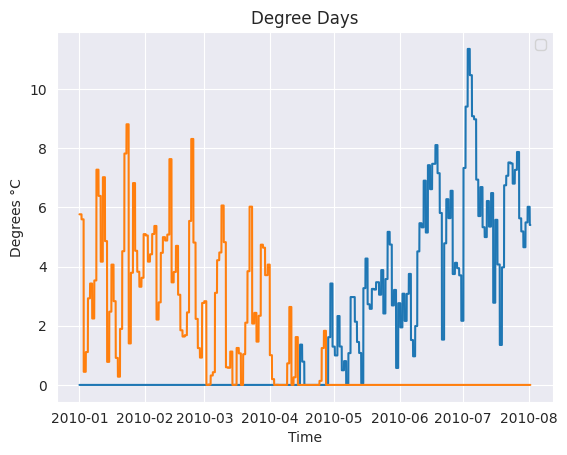

In [103]:
plt.plot(DD.iloc[1:10000])
plt.title("Degree Days")
plt.xlabel("Time")
plt.ylabel("Degrees °C")
plt.legend()
plt.show()